# Milestone 2

In [1]:
from ada import data
import pandas as pd
import requests
from bs4 import BeautifulSoup
from re import sub
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np

## Global data description

We chosed to only use the useful amazon datasets and not the global one. For sake of ease we also selected files with duplicated items reviews removed. We used the following files : 
* Reviews and metadata for books
* Reviews and metadata for Movies and TV
We decided not to use the reviews for Amazon Instant videos because a large majority of products are not related to a title, we have noticed that we could use the Amazon Product API but we think we have enough data with the 2 firsts categories.

We constructed our code so that we can handle both plain and compressed json files (`.json` and `.json.gz`), so that we can avoid extracting json files if memory is limited. 

We worked on our PC as the size of the data is small (about 8gb for compressed files and 25gb for plain files)

### Books reviews

* Number of lines : `wc -l reviews_Books.json  : 22507155 reviews_Books.json` which is coherent with the number given on the source website    

In [2]:
books_reviews_lines = data.read_data("reviews_Books", 5)
df = {}
i=0
for book_line in books_reviews_lines:
    df[i]=book_line
    i+=1
pd.DataFrame.from_dict(df,orient='index')

FloatProgress(value=0.0, max=5.0)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AH2L9G3DQHHAJ,0000000116,chris,"[5, 5]",Interesting Grisham tale of a lawyer that take...,4.0,Show me the money!,1019865600,"04 27, 2002"
1,A2IIIDRK3PRRZY,0000000116,Helene,"[0, 0]",The thumbnail is a shirt. The product shown i...,1.0,Listing is all screwed up,1395619200,"03 24, 2014"
2,A1TADCM7YWPQ8M,0000000868,Joel@AWS,"[10, 10]",I'll be honest. I work for a large online reta...,4.0,Not a Bad Translation,1031702400,"09 11, 2002"
3,AWGH7V0BDOJKB,0000013714,Barbara Marshall,"[0, 0]",It had all the songs I wanted but I had ordere...,4.0,Not the large print,1383177600,"10 31, 2013"
4,A3UTQPQPM4TQO0,0000013714,betty burnett,"[0, 0]","We have many of the old, old issue. But the nu...",5.0,I was disappointed that you would only allow m...,1374883200,"07 27, 2013"


Basic description of features : 
* reviewerID : ID of the reviewer
* asin : ID of the product, will be used to match metadata
* reviewerName : name of the reviewer
* helpful :  helpfulness rating of the review, for example in the first row : 5/5
* reviewText : Content of the review
* overall : rating of the product
* summary : summary of the review
* unixReviewTime : Unix time of the review
* reviewTime  : time of the review in " month day,year" format


In [10]:
#Warning Long operation
books_reviews_lines = data.read_data("reviews_Books", 22507155)
distinct_reviewers = set()
distinct_asin = set()
totalHelpful = 0
helpfulCount = 0
helpfulZero = 0
overallTotal = 0
overallCount = 0
minTime = 2000000000
maxTime = 0
for book_line in books_reviews_lines:
    distinct_reviewers.add(book_line["reviewerID"])
    distinct_asin.add(book_line["asin"])
    helpful = book_line["helpful"]
    if helpful[0] == 0 and helpful[1] == 0:
        helpfulZero += 1
    else:
        totalHelpful += helpful[0] / helpful[1]
        helpfulCount += 1

    overallTotal += book_line["overall"]
    unixTime = book_line["unixReviewTime"]
    maxTime = unixTime if unixTime > maxTime else maxTime
    minTime = unixTime if unixTime < minTime else minTime


KeyboardInterrupt: 

Results : 
* Number of distinct reviewers : 8026324 (35.66% of total)  : a reviewer give 2.8 reviews in mean
* Number of distinct products :  2330066 (10.35% of total)  : 9.66 reviews per product
* Helpful mean (without 0/0) : 0.7288443590389628
* Non rated hepfulness (0/0) : 10473154 (46.53% of total)
* Overall mean : 4.29575892643917
* Max unix Time : 1406073600 : Wednesday, July 23, 2014 
* Min unix Time : 832550400 : Monday, May 20, 1996

We can already notice a high mean for overall reviews

### Books metadata

* Number of lines : `wc -l meta_Books.json 2370585 meta_Books.json`

In [8]:
books_meta_lines = data.read_data("meta_Books", 6)
df = {}
i=0
for book_line in books_meta_lines:
    df[i]=book_line
    i+=1
pd.DataFrame.from_dict(df,orient='index')

FloatProgress(value=0.0, max=6.0)

,asin,salesRank,imUrl,categories,title,description,price,related
0,0001048791,{'Books': 6334800},http://ecx.images-amazon.com/images/I/51MKP0T4...,[[Books]],"The Crucible: Performed by Stuart Pankin, Jero...",NaN,NaN,NaN
1,0001048775,{'Books': 13243226},http://ecx.images-amazon.com/images/I/5166EBHD...,[[Books]],Measure for Measure: Complete &amp; Unabridged,William Shakespeare is widely regarded as the ...,NaN,NaN
2,0001048236,{'Books': 8973864},http://ecx.images-amazon.com/images/I/51DH145C...,[[Books]],The Sherlock Holmes Audio Collection,"&#34;One thing is certain, Sherlockians, put a...",9.26,"{'also_viewed': ['1442300191', '9626349786', '..."
3,0000401048,{'Books': 6448843},http://ecx.images-amazon.com/images/I/41bchvIf...,[[Books]],The rogue of publishers' row;: Confessions of ...,NaN,NaN,{'also_viewed': ['068240103X']}
4,0001019880,{'Books': 9589258},http://ecx.images-amazon.com/images/I/61LcHUdv...,[[Books]],Classic Soul Winner's New Testament Bible,NaN,5.39,"{'also_viewed': ['B003HMB5FC', '0834004593'], ..."
5,0001048813,NaN,http://ecx.images-amazon.com/images/I/41k5u0lr...,[[Books]],Archer Christmas 4 Tape Pack,NaN,NaN,NaN


Basic description of features : 
* asin : ID of the product
* salesRank : sales rank information
* imUrl : url of the product image
* categories : list of categories the product belongs to
* title : name of the product
* price : price in US dollars
* description : product description
* related : related products, for example product that was also bought
* brand : brand name


This time the file is small enough to load it in memory with pandas but due to the format of the input it's faster to make a custom read.

For example we can not use the `unique` function to list categories as they are in a list format which are unhashable

In [2]:
books_meta_lines = data.read_data("meta_Books", 2370585)
distinct_categories = set()
sales_rank_min = 100000000
sales_rank_max = 0
sales_rank_total = 0
sales_rank_count = 0
title_count = 0
description_count = 0
price_count = 0
price_total = 0
related_count = 0
for book_line in books_meta_lines:
    for c in book_line["categories"]:
        for v in c:
            distinct_categories.add(v)
    if "salesRank" in book_line:
        sales_rank_count+=1
        s_rank = book_line["salesRank"]["Books"]
        sales_rank_total += s_rank
        sales_rank_max = s_rank if s_rank > sales_rank_max else sales_rank_max
        sales_rank_min = s_rank if s_rank < sales_rank_min else sales_rank_min
    title_count += 1 if "title" in book_line else 0
    description_count += 1 if "description" in book_line else 0
    if "price" in book_line:
        price_count += 1
        price_total += book_line["price"]
    related_count += 1 if "related" in book_line else 0

FloatProgress(value=0.0, max=2370585.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

We then get the following results (we made multiple computations in different times, without launching the dataframe computation each time, so we show here a summary): 

In [10]:
meta_books_headers = ["Name","Mean","Count","Count (%)","Min","Max"]
meta_books_results = [["Price",17.62630714920411,1679410,70.84369469983147],
                      ["Sales rank",2837317.7674769713,1891017,79.77005675814198,1,14690268],
                      ["Title",None,1938767,81.78432749722116],
                      ["Description",None,1121358,47.303007485494085],
                       ["Related",None,1620429,68.3556590461848]
                     ]
pd.DataFrame(meta_books_results,columns=meta_books_headers)

,Name,Mean,Count,Count (%),Min,Max
0,Price,1.762631e+01,1679410,70.843695,NaN,NaN
1,Sales rank,2.837318e+06,1891017,79.770057,1.0,14690268.0
2,Title,NaN,1938767,81.784327,NaN,NaN
3,Description,NaN,1121358,47.303007,NaN,NaN
4,Related,NaN,1620429,68.355659,NaN,NaN


There are also `3935` distincts categories, containing obivously `Books`

We can notice that we have a lot of titles here, so our project is still viable for now. We also see that we have the number 1 of books sale, meaning it will probably have a lot of reviews and will be interesting to analyse.


### Movies reviews

* Number of lines : ```wc -l reviews_Movies_and_TV.json 4607047 reviews_Movies_and_TV.json```
* The features are the same than those of Books reviews, please see there the decription

In [6]:
movies_reviews_lines = data.read_data("reviews_Movies_and_TV", 5)
df = {}
i=0
for movie_line in movies_reviews_lines:
    df[i]=movie_line
    i+=1
pd.DataFrame.from_dict(df,orient='index')

FloatProgress(value=0.0, max=5.0)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3R5OBKS7OM2IR,0000143502,Rebecca L. Johnson,"[0, 0]",This has some great tips as always and is help...,5.0,Alton... nough said,1358380800,"01 17, 2013"
1,A3R5OBKS7OM2IR,0000143529,Rebecca L. Johnson,"[0, 0]",This is a great pastry guide. I love how Alto...,5.0,Ah Alton...,1380672000,"10 2, 2013"
2,AH3QC2PC1VTGP,0000143561,Great Home Cook,"[2, 4]",I have to admit that I am a fan of Giada's coo...,2.0,Don't waste your money,1216252800,"07 17, 2008"
3,A3LKP6WPMP9UKX,0000143588,Anna V. Carroll,"[9, 9]",I bought these two volumes new and spent over ...,5.0,VOLUME 1 & VOLUME 2-BETTER THAN THERAPY,1236902400,"03 13, 2009"
4,AVIY68KEPQ5ZD,0000143588,Rebecca Millington,"[1, 4]",I am very pleased with the dvd only wish i cou...,5.0,Barefoot Contesst Vol 2,1232236800,"01 18, 2009"


We will have the same approach than for book files, here we could have loaded the whole file in memory and worked with pandas but for the description this is not useful

Results : 
* Number of distinct reviewers : 2088620 (45.33 % of total) :  a reviewer give 2.2 reviews in mean
* Number of distinct products :  200941  (4.36 % of total ) : 22.9 reviews per product
* Helpful mean (without 0/0) : 0.6132033945128144
* Non rated hepfulness (0/0) : 1967621 (42.71% of total)
* Overall mean : 4.18688001229421
* Max unix Time : 1406073600 : Wednesday, July 23, 2014 
* Min unix Time : 871084800 : Saturday, August 9, 1997

There are clearly less distinct products (as a percentage) than for the books, so we should have more reviews per product. We can also notice a high mean for overall mean but slightly worse than for books. 

### Movies metadata

* Number of lines : `wc -l meta_Movies_and_TV.json  208321 meta_Movies_and_TV.json`
* The features are the same than those of Books metadata, please see there the description

In [7]:
movies_meta_lines = data.read_data("meta_Movies_and_TV", 5)
df = {}
i=0
for movie_line in movies_meta_lines:
    df[i]=movie_line
    i+=1
pd.DataFrame.from_dict(df,orient='index')

FloatProgress(value=0.0, max=5.0)

,asin,categories,description,title,price,salesRank,imUrl,related
0,0000143561,"[[Movies & TV, Movies]]","3Pack DVD set - Italian Classics, Parties and ...","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},http://g-ecx.images-amazon.com/images/G/01/x-s...,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '..."
1,0000589012,"[[Movies & TV, Movies]]",NaN,Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},http://ecx.images-amazon.com/images/I/519%2B1k...,"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
2,0000695009,"[[Movies & TV, Movies]]",NaN,Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},http://g-ecx.images-amazon.com/images/G/01/x-s...,NaN
3,000107461X,"[[Movies & TV, Movies]]",NaN,Live in Houston [VHS],NaN,{'Movies & TV': 954116},http://ecx.images-amazon.com/images/I/41WY47gL...,NaN
4,0000143529,"[[Movies & TV, Movies]]",Disc 1: Flour Power (Scones; Shortcakes; South...,My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},http://ecx.images-amazon.com/images/I/51QY79CD...,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '..."


In [11]:
meta_books_headers = ["Name","Mean","Count","Count (%)","Min","Max"]
meta_books_results = [["Price",23.48689486774547,155623,74.70346244497674],
                      ["Sales rank",391833.30351553153,204777,98.29877928773384,11,1149966],
                      ["Title",None,107671,51.685139760273806],
                      ["Description",None,178086,85.48634079137484],
                       ["Related",None,154859,74.33672073386745]
                     ]
pd.DataFrame(meta_books_results,columns=meta_books_headers)

,Name,Mean,Count,Count (%),Min,Max
0,Price,23.486895,155623,74.703462,NaN,NaN
1,Sales rank,391833.303516,204777,98.298779,11.0,1149966.0
2,Title,NaN,107671,51.685140,NaN,NaN
3,Description,NaN,178086,85.486341,NaN,NaN
4,Related,NaN,154859,74.336721,NaN,NaN


We have clearly less titles for the movies and this might be restrictive if too much of this titles are not connected to books. 
It is a bit weird to have the product description and not its title.
Once again there are many categories (786)

## Matching books and movies

We will do the matching between books and movies from the metadata titles, then once we have the interesting products we will merge the metadata and reviews (once for books, once for movies) for the mathcing products. 
Finally we will be able to make our compared analysis

For this milestone, we decided to focus on known associations of books and movies, we might consider matching products from both categories with other techniques for the final project. 

To obtain a list of association books-movies we decided to parse the [Wikipedia pages](https://en.wikipedia.org/wiki/Lists_of_fiction_works_made_into_feature_films) in this subject. 
Those pages are separated in 4 pages, depending on the book first letter.

In [20]:
def get_dict_titles(urlList):
    titles = {}
    for url in urlList:
        r = requests.get(url)
        soup = BeautifulSoup(r.text,"html5lib")
        tables = soup.findAll("table", {"class": "wikitable"})
        for table in tables:
            for row in table.findAll("tr"):
                cells = row.findAll("td")
                if len(cells) == 2:
                    movie_data = cells[1].findAll(text=True)
                    movie_titles = [movie_data[0]]
                    movie_titles_mult = [value for index, value in enumerate(
                        movie_data) if movie_data[(index - 1) % len(movie_data)] == '\n']
                    titles[cells[0].find(text=True)] = list(
                        set(movie_titles + movie_titles_mult))
    return titles

In [22]:
urlList = ["https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_(0%E2%80%939_and_A%E2%80%93C)",
           "https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_(D%E2%80%93J)",
           "https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_(K%E2%80%93R)",
           "https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_(S%E2%80%93Z)"]
dict_titles = get_dict_titles(urlList)

In [23]:
print(f"Number of books : {len(dict_titles.keys())}")
movies_titles = [item for sublist in dict_titles.values()
                 for item in sublist]
print(f"Number of movies : {len(movies_titles)}")

Number of books : 1635
Number of movies : 2253


Each book is associated to one or many movies. The goal is now to associate each movie/book title that we got here with an Amazon product ID (asin). 
For now we just clean both wikipedia and amazon titles and try to match exactly. 
Our cleaning is basic : we lower everything, we remove the puncuation, brackets, and keywords such as DVD and vhs. 
We should definitively improve this step to match more products but we are also limited by the time/size complexity : 
for example if we try to make a relatively expensive operation such as Levenshtein distance or Sequence Matcher, we have to apply it 1600 \* 2300000 times (about 4\*10⁹ operations) while using exact match is much faster because we don't need to iterate through dict keys.
One other problem is for books series, where the number play a very important role, if we consider only text distance we may match distinct books

We made a strong choice by removing everything matching the regex `\(.*\)`, e.g. eveything between brackets. It could happen that names of books/movies use special formula including those brackets, but we considered that the name would still be matchable without it. For amazon products it is sometimes indicating the year of the movie or a specification for the content. We have for example : `Original sin (Unrated version)` and `Original sin(R rated version)`, but it is still linked to the same book, so it match !

In [25]:
def clean_title(title):
    removable = ['[', ']', 'dvd', 'vhs',
                 '(', ')', ',', '.', '!', '?', ':', ';']
    title = title.lower()
    # title = sub("\((.*film.*|.*movie.*)\)", "", title)
    title = sub("\(.*\)", "", title)
    title = sub("\s+", " ", title)
    title = sub("\s$", "", title)
    title = sub("^\s", "", title)
    for r in removable:
        title = title.replace(r, "")
    return title

In [28]:
movies_titles = [item for sublist in dict_titles.values()
                 for item in sublist]
print(f"Number of movies from wikipedia : {len(movies_titles)}")

for i, mov in enumerate(movies_titles):
    movies_titles[i] = clean_title(mov)

movies_association = {el: [] for el in movies_titles}

movies_metada_lines = data.read_data("meta_Movies_and_TV", 208321)
for movie_line in movies_metada_lines:
    if 'title' in movie_line:
        title = clean_title(movie_line['title'])
        if title in movies_association:
            movies_association[title].append(movie_line)

print(f"Number of movies selected: {sum([1 if len(v) > 0 else 0 for _, v in movies_association.items()])}")


Number of movies from wikipedia : 2253


FloatProgress(value=0.0, max=208321.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Note that the previous number is the number of "wikipedia" movies that are selected, there are more products than this number as many products can match the same title (see previous explanation for an example).
We also did the same for books

In [29]:
books_titles = [book for book in dict_titles]
print(f"Number of books from wikipedia : {len(books_titles)}")

for i, book in enumerate(books_titles):
    books_titles[i] = clean_title(book)

books_association = {el: [] for el in books_titles}

books_metada_lines = data.read_data("meta_Books", 2370585)
for book_line in books_metada_lines:
    if 'title' in book_line:
        title = clean_title(book_line['title'])
        if title in books_association:
            books_association[title].append(book_line)
print(f"Number of books selected: {sum([1 if len(v) > 0 else 0 for _, v in books_association.items()])}")


Number of books from wikipedia : 1635


FloatProgress(value=0.0, max=2370585.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

Now that we matched products and titles for both movies and books, we should see how many pairs book/movies do we have (we may have matched product for a movie but not for a book or vice versa), we will also create new dictionnaries containing only those matches

In [ ]:
matching_book = []
matching_movies = []
total_selected = 0
for k, v in dict_titles.items():
    associate = False
    if len(books_association[clean_title(k)]) > 0:
        for mov in v:
            if len(movies_association[clean_title(mov)]) > 0:
                associate = True
                matching_movies.append(clean_title(mov))
    if associate:
        matching_book.append(clean_title(k))
    total_selected += 1 if associate else 0
print(f"Number of association book/movies : {total_selected}")

books_assocations_matching = {}
movies_association_matching = {}
for book in matching_book:
    books_assocations_matching[book] = books_association[book]
for movie in matching_movies:
    movies_association_matching[movie] = movies_association[movie]


We know cretate new associations dictionnaries which only contains matching items in both movies and books

We consider that, at least for this milestone, 500 pairs should be enough to get significant result. 
Anyway we build the following parts of our workflow independantly of this matching part so that we can easily improve it.

### Merging reviews and metadata

Now that we have matched the product id that we will use for the analysis, we want to merge for both books and movies the metadata with each review. 
After this step we will save our result to fresh new files in order to be able to load easily our data in dataframe and avoid expensive computations

First we will build new dataframes for reviews containing only interesting reviews. Then we will do the same for metadatas and finally we will merge both.

In [ ]:
# We will build new dicts has in python they are build over hash tables so we will be able to have
# a constant complexity for looking for the presence of a product id.
books_product_id = {}
for books in books_association.values():
    for book in books:
        books_product_id[book["asin"]] = book

movies_product_id = {}
for movies in movies_association.values():
    for movie in movies:
        movies_product_id[movie["asin"]] = movie

print(f"We have {len(movies_product_id.keys())} distincts product for movies")
print(f"We have {len(books_product_id.keys())} distincts product for books")


In [ ]:
def build_new_review_df(use_products, file, line_num):
    reviews_lines = data.read_data(file, line_num)
    i = 0
    df = {}
    for line in reviews_lines:
        if line["asin"] in use_products:
            df[i] = line
            i += 1
    return pd.DataFrame.from_dict(df, orient='index')

books_new_df = build_new_review_df(books_product_id, "reviews_Books", 22507155)
print(f"Number of books reviews after filtering : {books_new_df.shape}")
books_new_df.to_json("filtered_Books_reviews.json", orient='records')

movies_new_df = build_new_review_df(
    movies_product_id, "reviews_Movies_and_TV", 4607047)
print(f"Number of movies reviews after filtering : {movies_new_df.shape}")
movies_new_df.to_json("filtered_Movies_reviews.json", orient='records')

books_meta_filtered_df = build_new_review_df(
    books_product_id, "meta_Books", 2370585)
books_meta_filtered_df.to_json("filtered_Books_meta.json", orient='records')

movies_meta_filetered_df = build_new_review_df(
    movies_product_id, "meta_Movies_and_TV", 208321)
movies_meta_filetered_df.to_json("filtered_Movies_meta.json", orient='records')

In [ ]:
books_filtered = books_new_df.merge(books_meta_filtered_df,on="asin")
print(books_filtered.shape)
books_filtered.to_json("filtered_merged_Books.json",orient='records')

movies_filtered = movies_new_df.merge(movies_meta_filetered_df,on="asin")
print(movies_filtered.shape)
movies_filtered.to_json("filtered_merged_Movies.json",orient='records')
movies_filtered.head(5)

## Analysis of remaining data

We will remove non useful features from the dataframes (not useful for this milestone at this moment of analysis or redondant information). 

In [2]:
movies_df = pd.read_json("filtered_merged_Movies.json", orient='records')

In [3]:
books_df = pd.read_json("filtered_merged_Books.json", orient='records')

In [4]:
def filter_merged_df(df):
    df = df.drop("reviewTime", 1)
    df = df.drop("reviewerName", 1)
    df = df.drop("imUrl", 1)
    df = df.drop("categories", 1)
    df = df.drop("salesRank", 1)
    df['helpful'] = df['helpful'].apply(
        lambda x: None if x[1] == 0 else x[0] / x[1])
    df = df.drop("related", 1)
    return df
if "reviewTime" in movies_df.columns:
    books_df = filter_merged_df(books_df)
    movies_df = filter_merged_df(movies_df)
movies_df.head(5)

,asin,brand,description,helpful,overall,price,reviewText,reviewerID,summary,title,unixReviewTime
0,0767020308,LIONSGATE FILMS,From the producers of A&E;'s Emmy award winnin...,0.000000,4,29.99,I want it for my Austin collectionI love all t...,AXR7F7BO6EMJ3,4 out of 5,Emma,1363219200
1,0767020308,LIONSGATE FILMS,From the producers of A&E;'s Emmy award winnin...,0.666667,5,29.99,I love Kate Beckinsale as an actress (pre-Unde...,A1GJ5HAK5SKHH4,Pitch-perfect Emma,Emma,1242086400
2,0767020308,LIONSGATE FILMS,From the producers of A&E;'s Emmy award winnin...,0.500000,5,29.99,After reading Jane Austen's Emma and thoroughl...,A25Z83EB17KP7L,Beautiful Movie,Emma,1209081600
3,0767020308,LIONSGATE FILMS,From the producers of A&E;'s Emmy award winnin...,0.826087,3,29.99,"With Kate Beckinsale in the lead, this should ...",AEIY0OQITQ8M1,Not quite Miss Jane's Emma,Emma,1154044800
4,0767020308,LIONSGATE FILMS,From the producers of A&E;'s Emmy award winnin...,1.000000,5,29.99,Jane Austen as always delivers. The cast of a...,A28UKEMDNDSC9S,Excellent,Emma,1395360000


So we have the following features and their types : 
* asin : product number, string
* brand : brand of the product, string
* description : product description, string
* helpful : how helpful is the review considered, float with None if the data was [0,0]
* overall : overall note for the product between 1 and 5, int
* price : product price  in $ (at the time of crawling, it mays differ from the price paid by the user), float
* reviewText : Text content of the review, string
* reviewerID : Amazon id for the user, string
* summary : summary of the review, string
* title : Product title, string
* unixReviewTime : time of the review

In [5]:
movies_df.describe()

,helpful,overall,price,unixReviewTime
count,64241.000000,97132.000000,96215.000000,9.713200e+04
mean,0.557149,4.029805,13.451445,1.233093e+09
std,0.375112,1.359921,12.783699,1.385575e+08
min,0.000000,1.000000,0.010000,8.801568e+08
25%,0.214286,3.000000,5.000000,1.121990e+09
50%,0.600000,5.000000,9.370000,1.252714e+09
75%,1.000000,5.000000,15.590000,1.367021e+09
max,1.000000,5.000000,149.990000,1.406074e+09


In [6]:
books_df.describe()

,helpful,overall,price,unixReviewTime
count,60673.000000,118884.000000,117847.000000,1.188840e+05
mean,0.624955,4.262777,6.301936,1.245267e+09
std,0.389951,1.118692,4.592828,1.570926e+08
min,0.000000,1.000000,0.000000,8.514720e+08
25%,0.312500,4.000000,3.990000,1.104365e+09
50%,0.750000,5.000000,5.990000,1.332806e+09
75%,1.000000,5.000000,8.590000,1.373414e+09
max,2.000000,5.000000,124.530000,1.405987e+09


For description we will compute the missing values rate and the mean size of the text
For review and summary we will compute their size. 

In [7]:
books_null_desc = books_df['description'].isnull().sum()
movies_null_desc = movies_df['description'].isnull().sum()
print(f"Books description missing rate : {100*books_null_desc/books_df.shape[0]}%")
print(f"Movies description missing rate : {100*movies_null_desc/movies_df.shape[0]}%")
print()
print(f"Books description mean length : {books_df['description'].str.len().sum()/(books_df.shape[0] - books_null_desc)}")
print(f"Movies description mean length : {movies_df['description'].str.len().sum()/(movies_df.shape[0] - movies_null_desc)}")
print('*'*10)
print(f"Books review mean length : {books_df['reviewText'].str.len().sum()/books_df.shape[0]}")
print(f"Movies review mean length : {movies_df['reviewText'].str.len().sum()/movies_df.shape[0]}")
print('*'*10)
print(f"Books review mean length : {books_df['summary'].str.len().sum()/books_df.shape[0]}")
print(f"Movies review mean length : {movies_df['summary'].str.len().sum()/movies_df.shape[0]}")

Books description missing rate : 9.40833080986508%
Movies description missing rate : 6.825762879380637%

Books description mean length : 1368.4700415045636
Movies description mean length : 1165.3990188062141
**********
Books review mean length : 696.1658339221426
Movies review mean length : 765.2017769633077
**********
Books review mean length : 24.34411695434205
Movies review mean length : 26.216715397603263


We will plot data for overall score for both movies and books. We will also plot the mean for overall scores from previous computation about non filtered data. However we **can not** draw any conclusion for now, this is just to have a first preview

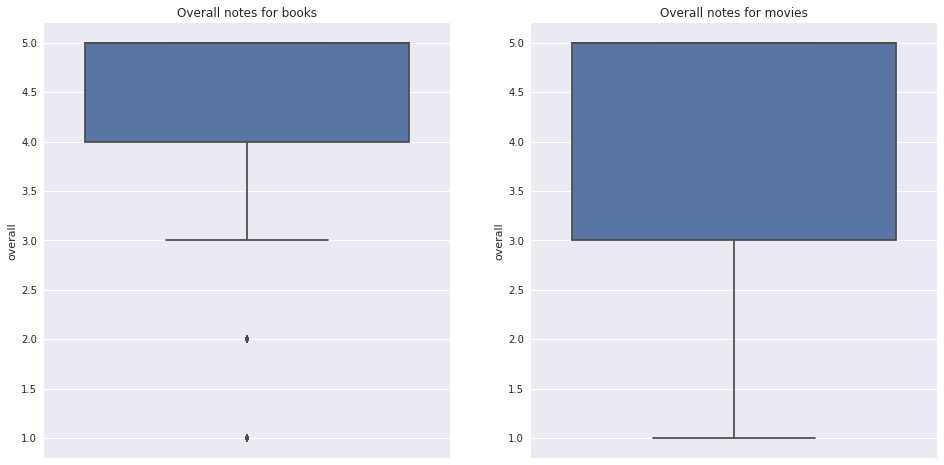

In [8]:
sb.set(style="darkgrid")
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y = 'overall' , data=books_df, ax = plot1)
plot1.set_title("Overall notes for books")

plot2 = sb.boxplot(y = 'overall' , data=movies_df, ax = plot2)
plot2.set_title("Overall notes for movies")

In [14]:
temp_df_plot = pd.DataFrame([["All books",4.2957],["Filtered books",books_df['overall'].mean()],["All movies",4.1868],["Filtered movies",movies_df["overall"].mean()]],columns=["Name","Value"])

Overall notes for books before and after filtering : 4.2957 and 4.262777160929982, difference of 0.7723331018043521%
Overall notes for movies before and after filtering : 4.1868 and 4.029804801713133, difference of 3.8958511891227596%


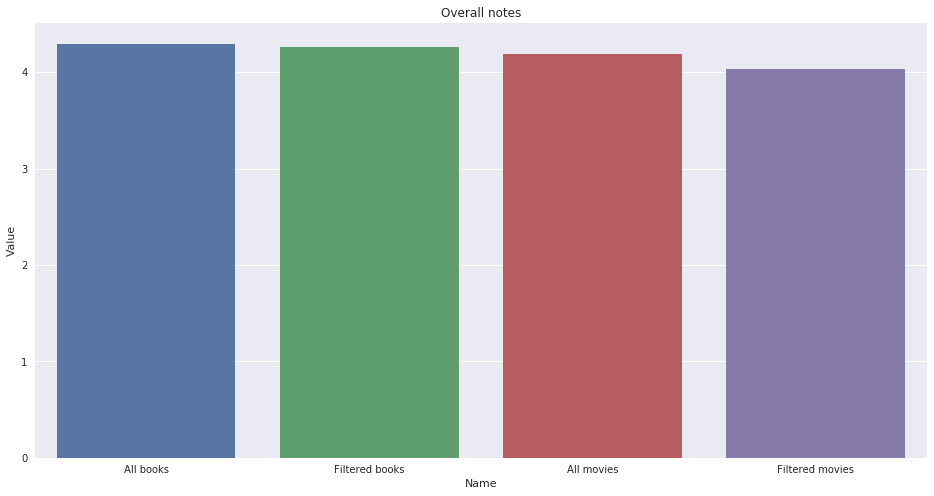

In [15]:
zone, plot = plt.subplots(ncols=1, sharey=True)
zone.set_size_inches(16, 8)
plot = sb.barplot(x="Name", y="Value", data=temp_df_plot)
plot.set_title("Overall notes")
print(f"Overall notes for books before and after filtering : {4.2957} and {books_df['overall'].mean()}, difference of {100*(4.2957-books_df['overall'].mean())/books_df['overall'].mean()}%")
print(f"Overall notes for movies before and after filtering : {4.1868} and {movies_df['overall'].mean()}, difference of {100*(4.1868-movies_df['overall'].mean())/movies_df['overall'].mean()}%")

We will make some plot to show any correlation between overall notes and other features, however we won't spend so much time for this analysis as it does not have a strong impact for our study. To make the plot readable we will take a 10% smaple for each dataframe

In [16]:
def plotCor(df1,df2,y,x,title):
    zone, (plot1, plot2) = plt.subplots(ncols=2)
    zone.set_size_inches(16, 6)

    plot1 = sb.regplot(y =y,x=x, data=df1, ax = plot1,x_bins=10)
    plot1.set_title(title +" for movies")

    plot2 = sb.regplot(y =y ,x= x, data=df2, ax = plot2,x_bins=10)
    plot2.set_title(title + " for books") 

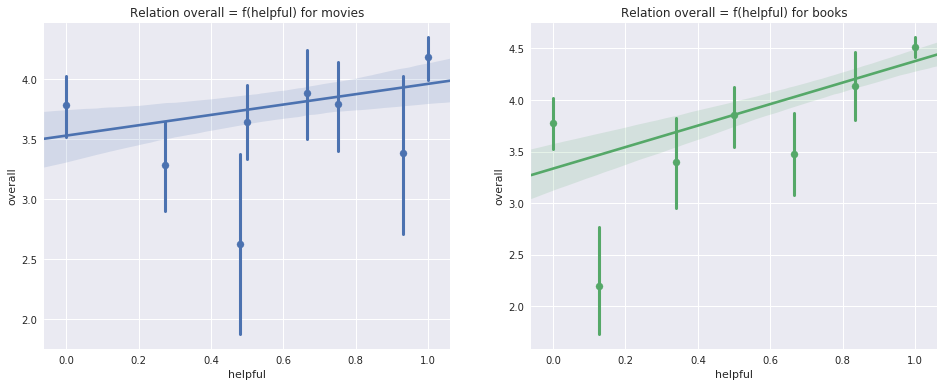

In [17]:
sample_movies = movies_df.sample(frac=0.01)
sample_movies['desc_length']=sample_movies["description"].str.len()
sample_movies['review_length']=sample_movies["reviewText"].str.len()
sample_books = books_df.sample(frac = 0.01)
sample_books['desc_length']=sample_books["description"].str.len()
sample_books['review_length']=sample_books["reviewText"].str.len()

plotCor(sample_movies,sample_books,"overall","helpful","Relation overall = f(helpful)")

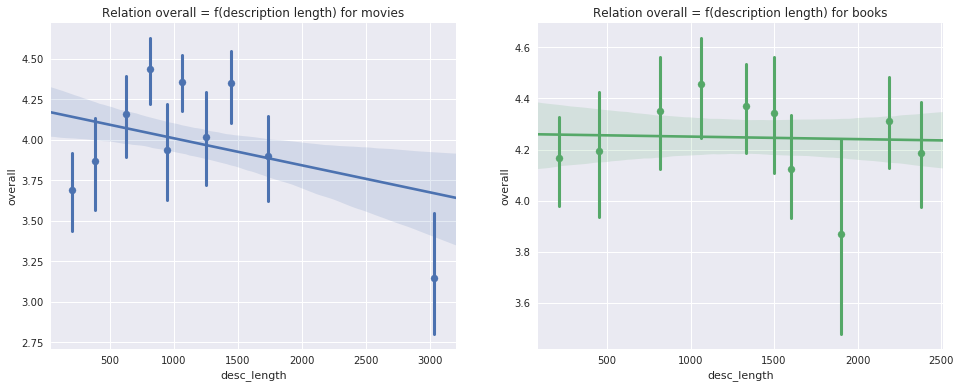

In [18]:
plotCor(sample_movies,sample_books,"overall","desc_length","Relation overall = f(description length)")

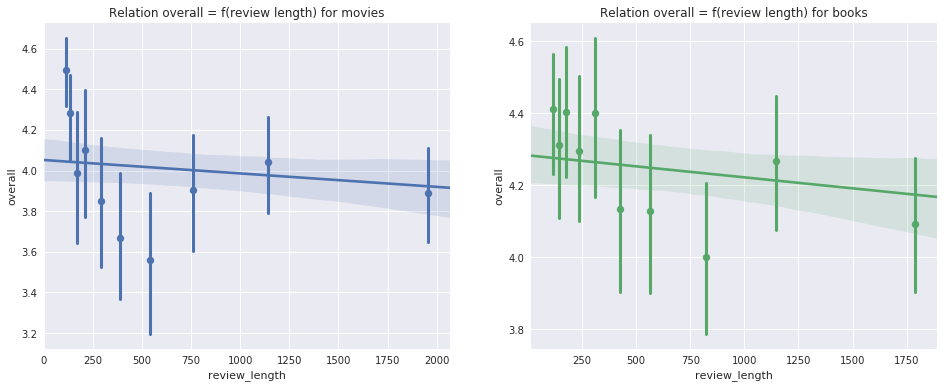

In [19]:
plotCor(sample_movies,sample_books,"overall","review_length","Relation overall = f(review length)")

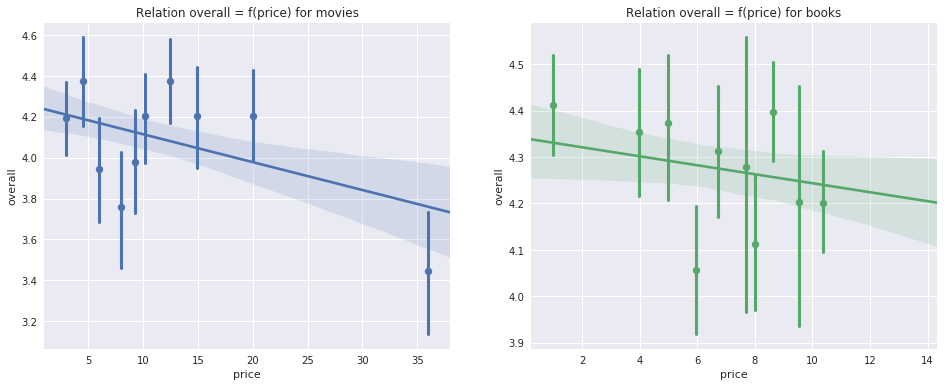

In [75]:
plotCor(sample_movies,sample_books,"overall","price","Relation overall = f(price)")

TODO or to do before end of project : sentiment analysis

## Analysis

In order to ease our different analysis we will add to each row an identifier wich corresponds to a certain franchise. This identifier will be the same for all books and movies products wich are linked to the same IP.

In [27]:
def add_franchise_id(df, franchise_dict):
    df['franchise_id']=df['asin'].apply(lambda x: franchise_dict[x])
    return df

product_to_franchise = {}
franchise_id = 0
for k, v in dict_titles.items():
    associate = False
    if clean_title(k) in books_match and len(books_match[clean_title(k)]) > 0:
        for mov in v:
            if clean_title(mov) in movies_match and len(movies_match[clean_title(mov)]) > 0:
                associate = True
                for movie_product in movies_match[clean_title(mov)]:
                    product_to_franchise[movie_product['asin']] = franchise_id
        for book_product in books_match[clean_title(k)]:
            product_to_franchise[book_product['asin']] = franchise_id
    franchise_id += 1 if associate else 0
books_df=add_franchise_id(books_df,product_to_franchise)
movies_df=add_franchise_id(movies_df,product_to_franchise)
books_df.head(5)

NameError: name 'books_match' is not defined

In [2]:
#TODO execute previous cells and don't load from the files
books_df = pd.read_json("merged_clean_Books.json",orient="records")
movies_df = pd.read_json("merged_clean_Movies.json",orient="records")

In [3]:
print(len(books_df['asin'].unique()))
print(len(movies_df['asin'].unique()))

2395
707


Let's try to see if same users gave reviews for both movies and books and then if we have some users that gave reviews for a pair movie/book

In [7]:
movies_users = movies_df['reviewerID'].unique()
books_users = books_df['reviewerID'].unique()
users_both = np.intersect1d(movies_users,books_users)
len(users_both)

4638

In [43]:
user_same_franchise = []
for user in users_both:
    movies_reviews_fr = movies_df[movies_df["reviewerID"]==user]["franchise_id"].unique()
    books_reviews_fr = books_df[books_df["reviewerID"]==user]["franchise_id"].unique()
    if len(np.intersect1d(movies_reviews_fr,books_reviews_fr))>0:
        user_same_franchise.append(user)

In [44]:
len(user_same_franchise)

1031

We have 1000 users which have given a review for both a movie and a book in the same franchise. This is a relatively small numbers and we will have to increase it for the next step but it should be enough for this milestone.
We also notice than nearly 1 over 4 person who gave a review for a movie and a book gave a review for a pair book/movie, wich is a big ratio

In [20]:
groupby_franchise_df = pd.DataFrame()
groupby_franchise_df["books_mean"] = books_df.groupby("franchise_id")["overall"].mean()
groupby_franchise_df["movies_mean"] = movies_df.groupby("franchise_id")["overall"].mean()
groupby_franchise_df.head(5)

,books_mean,movies_mean
franchise_id,,
0,4.367347,3.898396
1,4.297414,4.414286
2,3.678571,3.875676
3,4.095238,2.885417
4,4.530159,3.071429


In [38]:
groupby_franchise_df.describe()

,books_mean,movies_mean
count,505.000000,466.000000
mean,4.184440,3.962316
std,0.493395,0.620445
min,1.000000,1.000000
25%,4.000000,3.638638
50%,4.257353,4.053419
75%,4.467532,4.386014
max,5.000000,5.000000


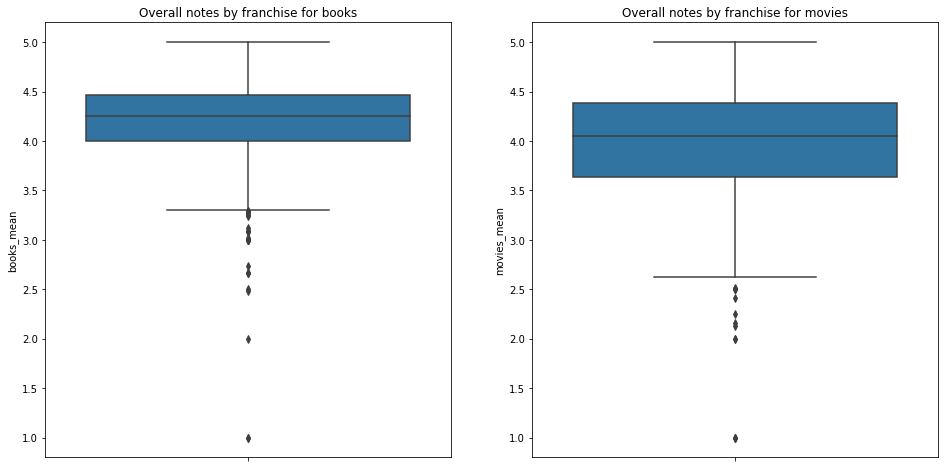

In [39]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y = 'books_mean' , data=groupby_franchise_df, ax = plot1)
plot1.set_title("Overall notes by franchise for books")

plot2 = sb.boxplot(y = 'movies_mean' , data=groupby_franchise_df, ax = plot2)
plot2.set_title("Overall notes by franchise for movies")

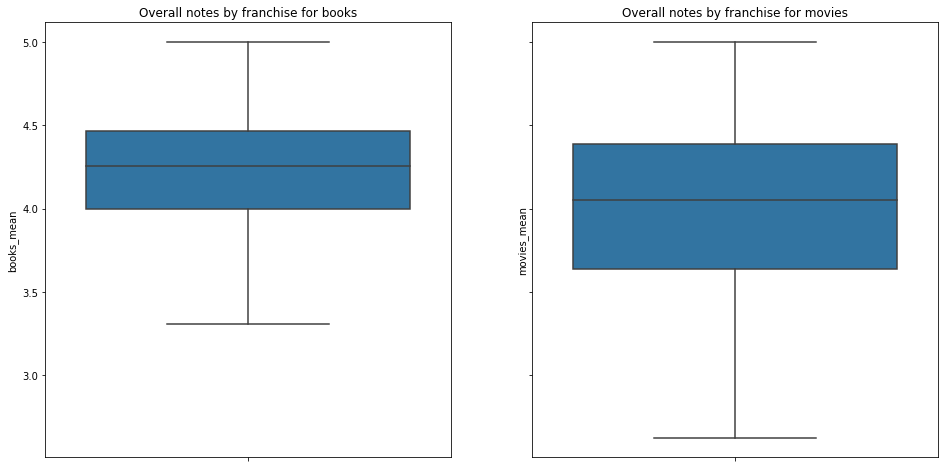

In [42]:
zone, (plot1, plot2) = plt.subplots(ncols=2,sharey=True)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y = 'books_mean' , data=groupby_franchise_df, ax = plot1,showfliers=False)
plot1.set_title("Overall notes by franchise for books")

plot2 = sb.boxplot(y = 'movies_mean' , data=groupby_franchise_df, ax = plot2,showfliers=False)
plot2.set_title("Overall notes by franchise for movies")

In [46]:
groupby_franchise_df[groupby_franchise_df["books_mean"]>groupby_franchise_df["movies_mean"]].shape[0]

283

In [49]:
user_franchise_df = pd.DataFrame(columns=["franchise_id","book_overall","movie_overall"])
for user in user_franchise_df:
    pass
#TODO make a df with a row for each user/franchise with the mean or overall given by the same user so that we can compare
# if users give better overall for books/movies